Loaded WDBC: X=(569, 30), y=(569,) (positive=malignant=1)
Train: (455, 30), Test: (114, 30)
Models included: 10
 - SVM (RBF Optimized)
 - SVM (Linear Optimized)
 - Logistic Regression (L1)
 - Logistic Regression (L2)
 - MLP Neural Network (Deep)
 - Random Forest (Optimized)
 - Extra Trees (Optimized)
 - Gradient Boosting (Optimized)
 - LightGBM (Optimized)
 - XGBoost (Optimized)

=== Table: Cross-Validation Summary (Mean ± SD) ===
                           Model  Accuracy (Mean)  Accuracy (SD)  Precision (Mean)  Precision (SD)  Recall (Mean)  Recall (SD)  F1 (Mean)   F1 (SD)  ROC-AUC (Mean)  ROC-AUC (SD)  Rank (Accuracy)
0       Logistic Regression (L2)         0.975845       0.024098          0.977451        0.039169       0.958824     0.048428   0.967159  0.032607        0.995226      0.008820                1
1      MLP Neural Network (Deep)         0.975797       0.019246          0.967509        0.044908       0.970588     0.041595   0.967839  0.025492        0.993958      0.0118

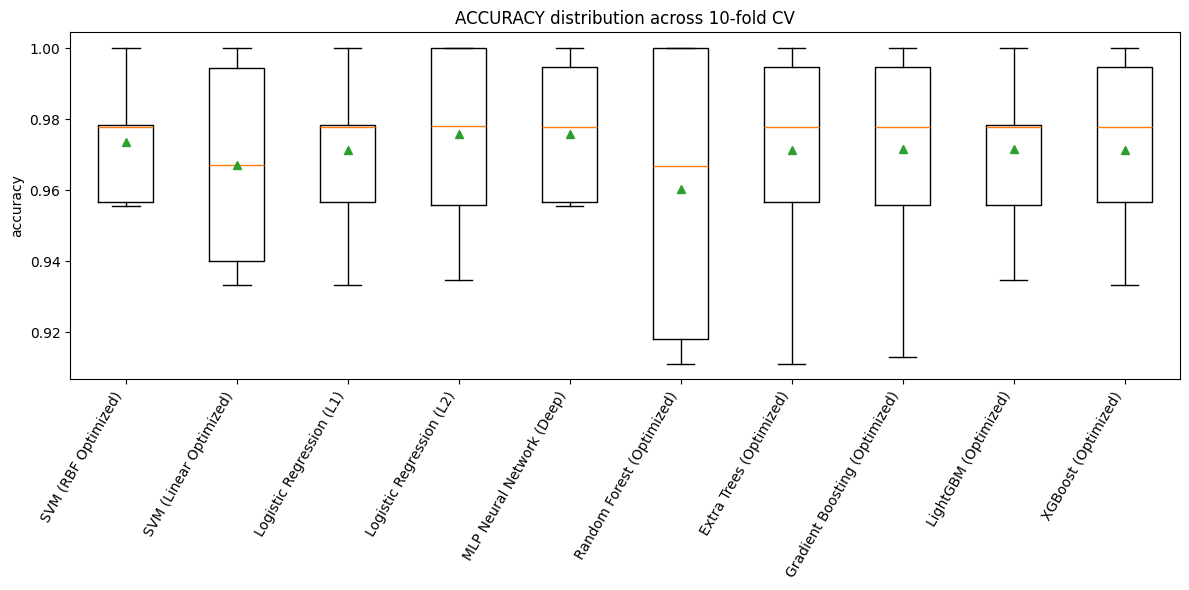

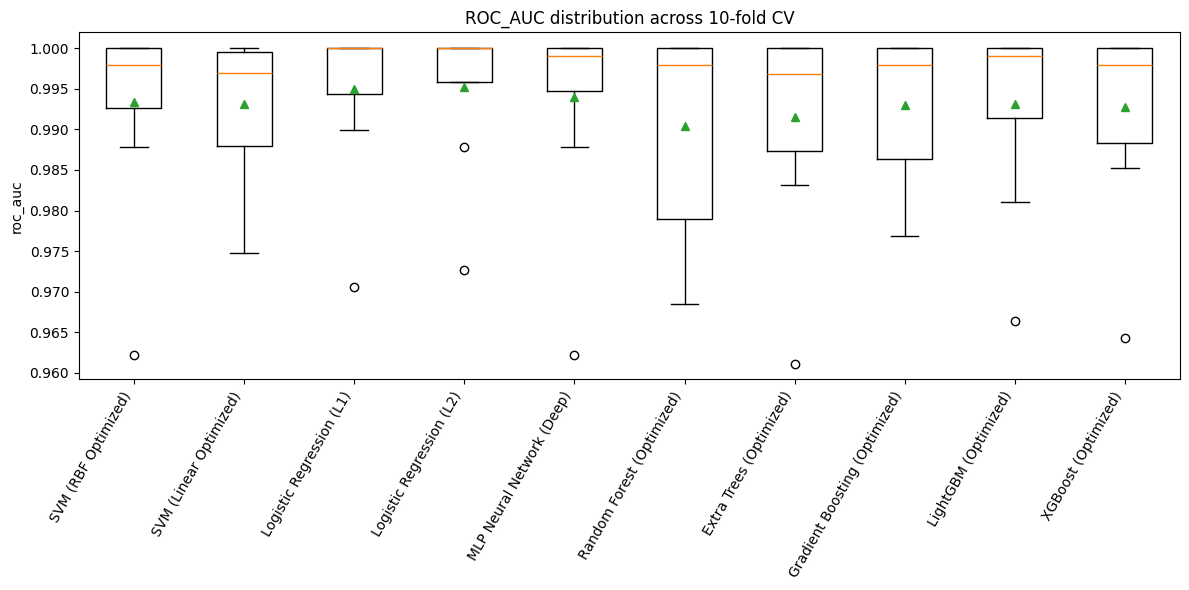


=== Best Model Test Set Evaluation ===
Confusion Matrix (rows=true [benign, malignant], cols=pred [benign, malignant]):
[[71  1]
 [ 3 39]]

Test set metrics:
                         Value
Accuracy              0.964912
Precision             0.975000
Recall (Sensitivity)  0.928571
F1-Score              0.951220
ROC-AUC               0.996032
Specificity           0.986111
False Positive Rate   0.013889
False Negative Rate   0.071429


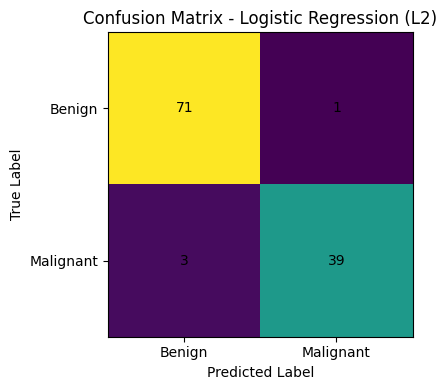

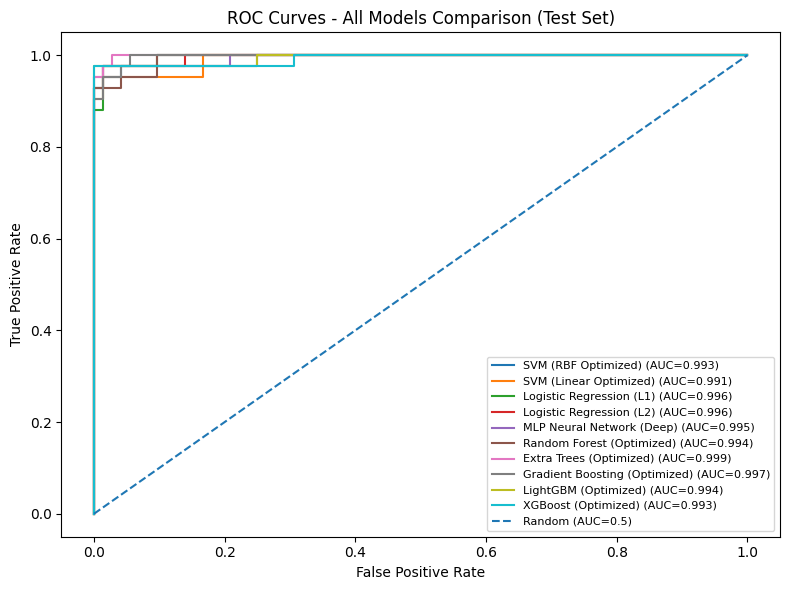

In [8]:
"""
Breast Cancer Diagnosis: Performance Benchmarking + Statistical Validation
- Dataset: Wisconsin Diagnostic Breast Cancer (WDBC), 569 samples, 30 features
- StandardScaler (z-score)
- 11 models (SVM RBF/Linear, LR L1/L2, MLP, RF, ExtraTrees, GB)
- Stratified 10-fold CV
- Metrics: Accuracy, Precision, Recall, F1, ROC-AUC
- Friedman + pairwise Wilcoxon vs best model (by mean accuracy)
- Stability boxplots (accuracy, ROC-AUC)
- Independent test-set evaluation + confusion matrix
- ROC curves on test set

"""

import os
import warnings
warnings.filterwarnings("ignore")
os.environ["LIGHTGBM_VERBOSE"] = "-1"

import numpy as np
import pandas as pd

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve
)

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier

from scipy.stats import friedmanchisquare, wilcoxon
import matplotlib.pyplot as plt

RANDOM_STATE = 42

CATBOOST_AVAILABLE = False
LGBM_AVAILABLE = False
XGB_AVAILABLE = False

try:
    from catboost import CatBoostClassifier
    CATBOOST_AVAILABLE = True
except Exception:
    pass

try:
    import lightgbm as lgb
    from lightgbm import LGBMClassifier
    LGBM_AVAILABLE = True

    try:
        lgb.register_logger(lambda msg: None)
    except Exception:
        pass

    warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")
except Exception:
    pass

try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    pass

# Data

def load_wdbc():
    data = load_breast_cancer()
    X = data.data
    y = data.target
    y = 1 - y
    return X, y, data.feature_names

# Models

def build_models():
    """
    Table-1 style hyperparameters from the PDF.
    All wrapped in Pipeline with StandardScaler to match the preprocessing setup.
    """
    models = {}

    # SVMs
    models["SVM (RBF Optimized)"] = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(C=10, gamma="scale", kernel="rbf", probability=True, random_state=RANDOM_STATE))
    ])

    models["SVM (Linear Optimized)"] = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", SVC(C=1.0, kernel="linear", probability=True, random_state=RANDOM_STATE))
    ])

    # Logistic Regression
    models["Logistic Regression (L1)"] = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            penalty="l1", C=1.0, solver="liblinear", max_iter=5000, random_state=RANDOM_STATE
        ))
    ])

    models["Logistic Regression (L2)"] = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(
            penalty="l2", C=1.0, solver="lbfgs", max_iter=5000, random_state=RANDOM_STATE
        ))
    ])

    # MLP Deep
    models["MLP Neural Network (Deep)"] = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", MLPClassifier(
            hidden_layer_sizes=(256, 128, 64, 32),
            activation="relu",
            solver="adam",
            alpha=1e-4,
            learning_rate="adaptive",
            max_iter=2000,
            random_state=RANDOM_STATE
        ))
    ])

    # Ensembles / boosting
    models["Random Forest (Optimized)"] = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=RANDOM_STATE))
    ])

    models["Extra Trees (Optimized)"] = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", ExtraTreesClassifier(n_estimators=500, n_jobs=-1, random_state=RANDOM_STATE))
    ])

    models["Gradient Boosting (Optimized)"] = Pipeline([
        ("scaler", StandardScaler()),
        ("clf", GradientBoostingClassifier(n_estimators=300, random_state=RANDOM_STATE))
    ])

    # CatBoost
    if CATBOOST_AVAILABLE:
        models["CatBoost (Optimized)"] = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", CatBoostClassifier(
                iterations=500,
                depth=6,
                learning_rate=0.1,
                loss_function="Logloss",
                verbose=False,
                random_seed=RANDOM_STATE
            ))
        ])

    # LightGBM (QUIET)
    if LGBM_AVAILABLE:
        models["LightGBM (Optimized)"] = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LGBMClassifier(
                n_estimators=500,
                random_state=RANDOM_STATE,
                n_jobs=-1,

                verbosity=-1,
                verbose=-1,

                min_gain_to_split=0.0,
                min_data_in_leaf=20,
                min_sum_hessian_in_leaf=1e-3
            ))
        ])

    # XGBoost (QUIET)
    if XGB_AVAILABLE:
        models["XGBoost (Optimized)"] = Pipeline([
            ("scaler", StandardScaler()),
            ("clf", XGBClassifier(
                n_estimators=500,
                random_state=RANDOM_STATE,
                n_jobs=-1,
                eval_metric="logloss",
                verbosity=0  # <- quiet
            ))
        ])

    return models

# CV evaluation

def crossval_evaluate(models, X, y, n_splits=10):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

    results = {}
    for name, pipeline in models.items():
        fold_metrics = {"accuracy": [], "precision": [], "recall": [], "f1": [], "roc_auc": []}

        for tr_idx, va_idx in skf.split(X, y):
            X_tr, X_va = X[tr_idx], X[va_idx]
            y_tr, y_va = y[tr_idx], y[va_idx]

            pipeline.fit(X_tr, y_tr)
            y_pred = pipeline.predict(X_va)

            # Probabilities for ROC-AUC
            clf = pipeline.named_steps["clf"]
            if hasattr(clf, "predict_proba"):
                y_prob = pipeline.predict_proba(X_va)[:, 1]
            else:
                scores = pipeline.decision_function(X_va)
                y_prob = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)

            fold_metrics["accuracy"].append(accuracy_score(y_va, y_pred))
            fold_metrics["precision"].append(precision_score(y_va, y_pred, zero_division=0))
            fold_metrics["recall"].append(recall_score(y_va, y_pred, zero_division=0))
            fold_metrics["f1"].append(f1_score(y_va, y_pred, zero_division=0))
            fold_metrics["roc_auc"].append(roc_auc_score(y_va, y_prob))

        results[name] = fold_metrics

    return results


def summarize_results(cv_results):
    rows = []
    for model, m in cv_results.items():
        rows.append({
            "Model": model,
            "Accuracy (Mean)": np.mean(m["accuracy"]),
            "Accuracy (SD)": np.std(m["accuracy"], ddof=1),
            "Precision (Mean)": np.mean(m["precision"]),
            "Precision (SD)": np.std(m["precision"], ddof=1),
            "Recall (Mean)": np.mean(m["recall"]),
            "Recall (SD)": np.std(m["recall"], ddof=1),
            "F1 (Mean)": np.mean(m["f1"]),
            "F1 (SD)": np.std(m["f1"], ddof=1),
            "ROC-AUC (Mean)": np.mean(m["roc_auc"]),
            "ROC-AUC (SD)": np.std(m["roc_auc"], ddof=1),
        })

    df = pd.DataFrame(rows)
    df["Rank (Accuracy)"] = df["Accuracy (Mean)"].rank(ascending=False, method="min").astype(int)
    df = df.sort_values(["Rank (Accuracy)", "Model"]).reset_index(drop=True)
    return df

# Statistics

def friedman_test(cv_results):
    acc_arrays = [np.array(v["accuracy"]) for v in cv_results.values()]
    stat, p = friedmanchisquare(*acc_arrays)
    return stat, p


def wilcoxon_vs_best(cv_results, best_model_name, alpha=0.05):
    best_acc = np.array(cv_results[best_model_name]["accuracy"])
    out = []

    for model, m in cv_results.items():
        if model == best_model_name:
            continue
        acc = np.array(m["accuracy"])
        stat, p = wilcoxon(best_acc, acc, zero_method="wilcox", alternative="two-sided")
        out.append({
            "Comparison Model": model,
            "Wilcoxon p-value": float(p),
            "Significant (alpha=0.05)": "Yes" if p < alpha else "No"
        })

    return pd.DataFrame(out).sort_values("Wilcoxon p-value").reset_index(drop=True)


# Test set eval

def test_set_evaluation(best_pipeline, X_train, y_train, X_test, y_test):
    best_pipeline.fit(X_train, y_train)
    y_pred = best_pipeline.predict(X_test)

    clf = best_pipeline.named_steps["clf"]
    if hasattr(clf, "predict_proba"):
        y_prob = best_pipeline.predict_proba(X_test)[:, 1]
    else:
        scores = best_pipeline.decision_function(X_test)
        y_prob = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)

    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1v = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_test, y_prob)

    specificity = tn / (tn + fp + 1e-12)
    fpr = fp / (fp + tn + 1e-12)
    fnr = fn / (fn + tp + 1e-12)

    metrics = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall (Sensitivity)": rec,
        "F1-Score": f1v,
        "ROC-AUC": auc,
        "Specificity": specificity,
        "False Positive Rate": fpr,
        "False Negative Rate": fnr
    }
    return cm, metrics


# Plots

def plot_cv_distributions(cv_results, metric="accuracy"):
    labels = list(cv_results.keys())
    data = [cv_results[m][metric] for m in labels]

    plt.figure(figsize=(12, 6))
    plt.boxplot(data, labels=labels, vert=True, showmeans=True)
    plt.xticks(rotation=60, ha="right")
    plt.ylabel(metric)
    plt.title(f"{metric.upper()} distribution across 10-fold CV")
    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(cm, title="Confusion Matrix"):
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xticks([0, 1], ["Benign", "Malignant"])
    plt.yticks([0, 1], ["Benign", "Malignant"])
    for (i, j), val in np.ndenumerate(cm):
        plt.text(j, i, str(val), ha="center", va="center")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()


def plot_roc_curves_on_test(models, X_train, y_train, X_test, y_test):
    plt.figure(figsize=(8, 6))

    for name, pipeline in models.items():
        pipeline.fit(X_train, y_train)

        clf = pipeline.named_steps["clf"]
        if hasattr(clf, "predict_proba"):
            y_prob = pipeline.predict_proba(X_test)[:, 1]
        else:
            scores = pipeline.decision_function(X_test)
            y_prob = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

    plt.plot([0, 1], [0, 1], linestyle="--", label="Random (AUC=0.5)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves - All Models Comparison (Test Set)")
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

# Main

def main():
    X, y, feature_names = load_wdbc()
    print(f"Loaded WDBC: X={X.shape}, y={y.shape} (positive=malignant=1)")

    # Independent test set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
    )
    print(f"Train: {X_train.shape}, Test: {X_test.shape}")

    # Models
    models = build_models()
    print(f"Models included: {len(models)}")
    for m in models:
        print(" -", m)

    # 10-fold CV on training portion
    cv_results = crossval_evaluate(models, X_train, y_train, n_splits=10)

    # Summary table
    summary_df = summarize_results(cv_results)
    pd.set_option("display.width", 200)
    pd.set_option("display.max_colwidth", 60)
    pd.set_option("display.max_rows", 200)

    print("\n=== Table: Cross-Validation Summary (Mean ± SD) ===")
    print(summary_df)

    # Friedman
    f_stat, f_p = friedman_test(cv_results)
    print("\n=== Friedman Test (Accuracy across models) ===")
    print(f"Statistic={f_stat:.4f}, p-value={f_p:.4f}")

    # Best model by mean accuracy
    best_model = summary_df.sort_values("Accuracy (Mean)", ascending=False).iloc[0]["Model"]
    print(f"\nBest model by mean CV accuracy: {best_model}")

    # Wilcoxon vs best
    wdf = wilcoxon_vs_best(cv_results, best_model_name=best_model, alpha=0.05)
    print("\n=== Wilcoxon Signed-Rank: Best vs Others (Accuracy) ===")
    print(wdf)

    # Stability plots
    plot_cv_distributions(cv_results, metric="accuracy")
    plot_cv_distributions(cv_results, metric="roc_auc")

    # Test set evaluation
    best_pipeline = models[best_model]
    cm, test_metrics = test_set_evaluation(best_pipeline, X_train, y_train, X_test, y_test)

    print("\n=== Best Model Test Set Evaluation ===")
    print("Confusion Matrix (rows=true [benign, malignant], cols=pred [benign, malignant]):")
    print(cm)

    test_metrics_df = pd.DataFrame([test_metrics]).T
    test_metrics_df.columns = ["Value"]
    print("\nTest set metrics:")
    print(test_metrics_df)

    plot_confusion_matrix(cm, title=f"Confusion Matrix - {best_model}")

    # ROC curves across all models on test set
    plot_roc_curves_on_test(models, X_train, y_train, X_test, y_test)


if __name__ == "__main__":
    main()
